# ARIMA Model
In this notebook, we will build an ARIMA model to predict the stock price. First we read the combined tapes `Tapes_all.csv` and resample the data by 1 hour. Then we will check the stationarity of the data and if necessary, we will difference the data. Finally, we will try to find the best orders for ARIMA model and train the dataset.

## 1. Load and Resample Data

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
tape_data=pd.read_csv('../datasets/Tapes_all.csv')

In [3]:
# Combine 'Date' and 'Timestamp' into a datetime, assuming 'Timestamp' is in seconds and 'Date' is already in a compatible format
tape_data['Datetime'] = pd.to_datetime(tape_data['Date']) + pd.to_timedelta(tape_data['Timestamp'], unit='s')

# Set the new 'Datetime' column as the index
tape_data.set_index('Datetime', inplace=True)

# Drop the original 'Timestamp' and 'Date' columns as they are no longer needed
tape_data.drop(['Timestamp', 'Date'], axis=1, inplace=True)

# Show the first few rows of the dataframe to confirm changes
tape_data

,Price,Volume
Datetime,,
2025-01-02 00:00:10.881,267,1
2025-01-02 00:00:11.067,269,1
2025-01-02 00:00:11.222,267,2
2025-01-02 00:00:12.338,270,2
2025-01-02 00:00:13.733,267,3
...,...,...
2025-07-01 08:29:54.706,108,2
2025-07-01 08:29:55.481,108,2
2025-07-01 08:29:56.349,108,3


In [4]:
# 按小时重采样 resample the data by 1 hour
tape_data_hourly = tape_data.resample('H').agg({'Price': 'mean', 'Volume': 'sum'})

# 删除任何含有NaN值的行，因为重采样可能会在没有数据的时间段产生NaN值
tape_data_hourly.dropna(inplace=True)

# 修改列名
tape_data_hourly.columns = ['Price_mean', 'Volume_sum']

tape_data_hourly

,Price_mean,Volume_sum
Datetime,,
2025-01-02 00:00:00,259.120410,6075
2025-01-02 01:00:00,264.063928,6083
2025-01-02 02:00:00,280.758406,5505
2025-01-02 03:00:00,290.529842,5307
2025-01-02 04:00:00,289.701861,5611
...,...,...
2025-07-01 04:00:00,107.898117,6588
2025-07-01 05:00:00,108.078437,6628
2025-07-01 06:00:00,107.358943,6518


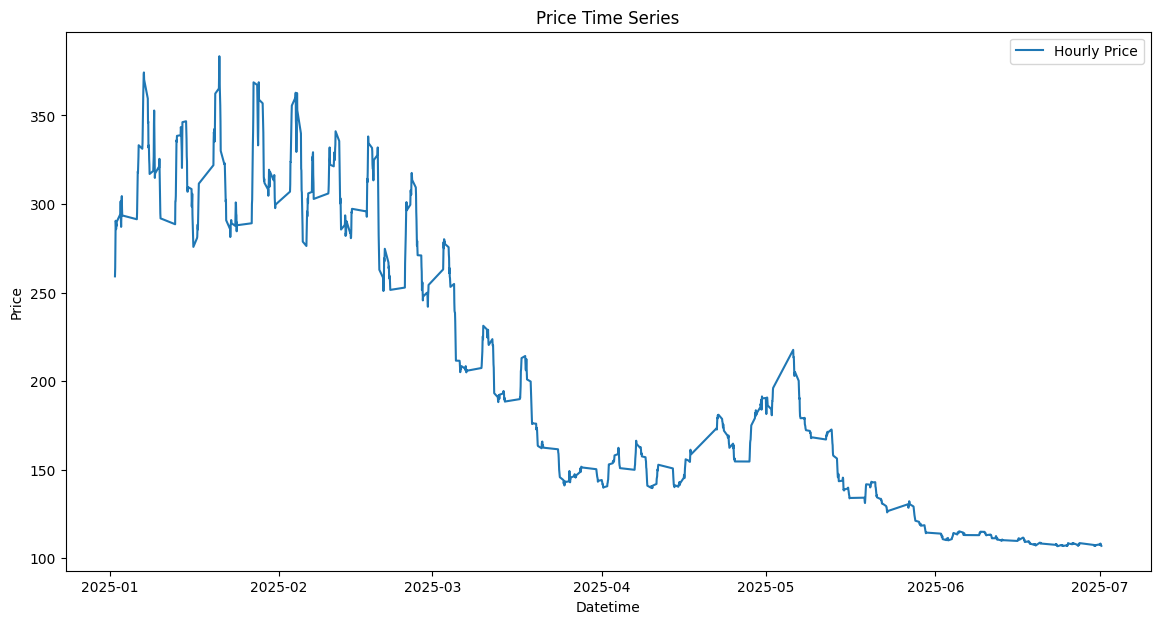

In [5]:
# 绘制价格的时间序列图 draw the time series graph
plt.figure(figsize=(14,7))
plt.plot(tape_data_hourly['Price_mean'], label='Hourly Price')
plt.title('Price Time Series')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

### 2. Seasonal
We can find that there seems to be a seasonal pattern in the time series. Every 7 days, there is a peak in the price. This is a good indication that the time series has a seasonal component.

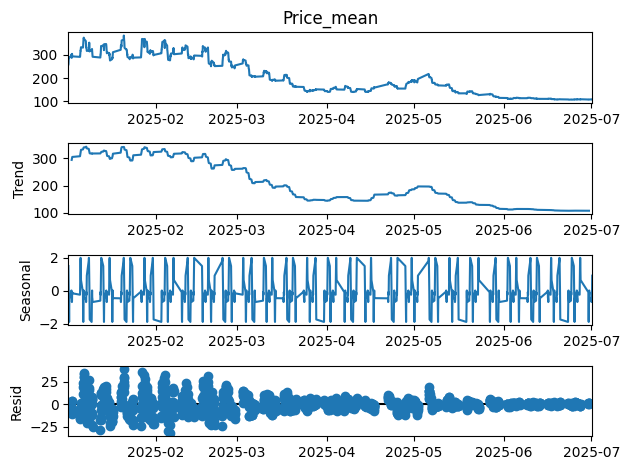

In [12]:
# 对时间序列进行分解
decomposition = seasonal_decompose(tape_data_hourly['Price_mean'], model='additive', period=24) # 假设每天有24小时的周期性

# 绘制分解的结果
decomposition.plot()
plt.show()

1. **时间序列图**：价格随时间的变化显示了一定的趋势，价格整体呈下降趋势。价格数据似乎有高峰和低谷，但没有明显的周期性模式。

2. **自相关图**：显示了显著的正自相关性，这在时间序列数据中是常见的，特别是对于股票价格。这意味着过去的价格对未来的价格有很强的影响。然而，我们还看不到明显的周期性模式，自相关图并没有呈现出明显的“波动”模式。

3. **时间序列分解图**：
   - **趋势分量**：明显显示了下降趋势，这可能表明市场在分析期内有一定的下行压力。
   - **季节性分量**：在您选择的分解频率下，我们可以看到有规律的波动，这表明有短期的季节性模式。
   - **残差分量**：看起来比较随机，这是好的，意味着模型已经从数据中提取了大部分信息。

价格数据具有强烈的时间相关性和一些短期的季节性模式。在选择预测模型时，这些信息非常有用。例如，ARIMA模型需要考虑到数据的非季节性和季节性成分，而机器学习模型可能需要特征工程来包含时间延迟作为输入。

In [13]:
# 分割数据为训练集和测试集
split_point = int(len(tape_data_hourly) * 0.8)
train, test = tape_data_hourly[0:split_point], tape_data_hourly[split_point:]

# 检查时间序列的平稳性
adf_test = adfuller(train['Price_mean'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.729097
p-value: 0.839068


In [14]:
# 对价格进行第一次差分
train['Price_diff'] = train['Price_mean'].diff().dropna()

# 再次进行ADF检验
adf_test_diff = adfuller(train['Price_diff'].dropna())

print('ADF Statistic (diff): %f' % adf_test_diff[0])
print('p-value (diff): %f' % adf_test_diff[1])

# 如果时间序列在第一次差分后仍不平稳，可以进行第二次差分
if adf_test_diff[1] > 0.05:
    train['Price_diff2'] = train['Price_diff'].diff().dropna()
    # 再次进行ADF检验
    adf_test_diff2 = adfuller(train['Price_diff2'].dropna())
    print('ADF Statistic (diff2): %f' % adf_test_diff2[0])
    print('p-value (diff2): %f' % adf_test_diff2[1])

# p-value=0--->平稳,则使用一阶差分，d=1

ADF Statistic (diff): -9.143096
p-value (diff): 0.000000


C:\Users\yhb\AppData\Local\Temp\ipykernel_1820\1672809309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price_diff'] = train['Price_mean'].diff().dropna()


### 3. ADF Statistic
First we check the stationarity of the time series using the ADF test. The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value is less than 0.05, we reject the null hypothesis and say that the time series is stationary.

When we use the original time series, the p-value is greater than 0.05, which means the time series is non-stationary. We need to difference the time series.

We use one differencing and the p-value is less than 0.05, which means the time series is stationary. We can use d=1 in the ARIMA model.

C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


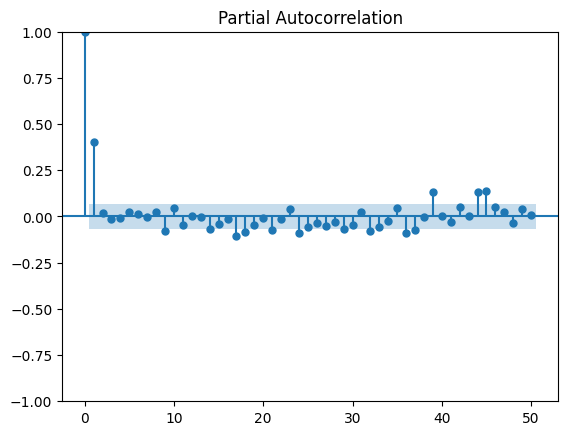

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

# 绘制偏自相关图
plot_pacf(train['Price_diff'].dropna(), lags=50)
plt.show()

#### PCAF图的解释
在滞后1处，偏自相关系数显著高于其他滞后，这意味着序列的当前值与其前一个值之间存在强相关性，且不受其他滞后值的影响。
大部分的偏自相关系数在滞后1之后都在零附近波动，且没有突破置信区间，这通常表示没有其他显著的自回归效应。

From the PACF plot, we can see that the partial autocorrelation at lag 1 is significantly high, and then it drops off. This is a good indication that the time series has an autoregressive component of order 1, or AR(1). p=1

### 4. SARIMA Model

Use the `auto_arima` function to automatically select the best ARIMA model. The auto_arima function can automatically select the best ARIMA model based on the AIC, BIC, and HQIC information criteria. It can also perform a grid search to find the best model based on the lowest AIC, BIC, or HQIC value.

However, the parameters selected from auto_arima may not be the best, so we can manually adjust the parameters based on the results of the models.

We can find that there seems to be a seasonal pattern in the time series. Every 7 days, there is a peak in the price. So we choose to set the seasonal parameter to True and the seasonal period `m` to 7 days(7*9 hours per day).

In [45]:
tape_data_hourly.dropna(inplace=True)
# auto_arima函数可以自动选择最佳的ARIMA模型
model = auto_arima(tape_data_hourly['Price_mean'], information_criterion='hqic',
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   start_P=0, seasonal=True, m=9*7,
                   d=1, D=1, start_Q=0, max_P=2, max_Q=2,
                   trace=True, 
                   error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize hqic
 ARIMA(0,1,0)(0,1,0)[63]             : HQIC=6970.727, Time=6.18 sec
 ARIMA(1,1,0)(1,1,0)[63]             : HQIC=inf, Time=12.56 sec
 ARIMA(0,1,1)(0,1,1)[63]             : HQIC=inf, Time=67.37 sec
 ARIMA(0,1,0)(1,1,0)[63]             : HQIC=inf, Time=13.19 sec
 ARIMA(0,1,0)(0,1,1)[63]             : HQIC=inf, Time=271.64 sec
 ARIMA(0,1,0)(1,1,1)[63]             : HQIC=inf, Time=48.80 sec
 ARIMA(1,1,0)(0,1,0)[63]             : HQIC=6730.347, Time=3.00 sec
 ARIMA(1,1,0)(0,1,1)[63]             : HQIC=inf, Time=50.57 sec
 ARIMA(1,1,0)(1,1,1)[63]             : HQIC=inf, Time=65.65 sec
 ARIMA(2,1,0)(0,1,0)[63]             : HQIC=6727.669, Time=4.30 sec
 ARIMA(2,1,0)(1,1,0)[63]             : HQIC=inf, Time=22.45 sec
 ARIMA(2,1,0)(0,1,1)[63]             : HQIC=inf, Time=60.77 sec
 ARIMA(2,1,0)(1,1,1)[63]             : HQIC=inf, Time=104.99 sec
 ARIMA(3,1,0)(0,1,0)[63]             : HQIC=6731.458, Time=5.17 sec
 ARIMA(2,1,1)(0,1,0)[63]             : HQI

In [54]:
# 使用auto_arima函数选择的最佳模型进行预测
# 划分数据集 split the data into train and test
train = tape_data_hourly['Price_mean'][:int(0.8*(len(tape_data_hourly)))]
test = tape_data_hourly['Price_mean'][int(0.8*(len(tape_data_hourly))):]

# 训练模型，order表示p,d,q的值. create the SARIMA model
model = SARIMAX(train, order=(2, 1, 0), seasonal_order=(0, 1, 0, 63),dynamic=True)
results = model.fit(disp=-1)#disp<0表示不输出收敛信息


# 模型预测,get_forecast(steps=len(test))表示预测test的长度，如果要预测整个数据集，可以使用get_forecast(steps=len(tape_data_hourly))
# forcast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# predict
y_pred = results.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# calculate the RMSE as the evaluation metric
# RMSE,使用mean_squared_error函数计算均方根误差
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print('RMSE for forcast:', rmse)

rmse2 = np.sqrt(mean_squared_error(test, y_pred))
print('RMSE for predict:', rmse2)

C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE for forcast: 7.700475894019058
RMSE for predict: 7.700475894019058


C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


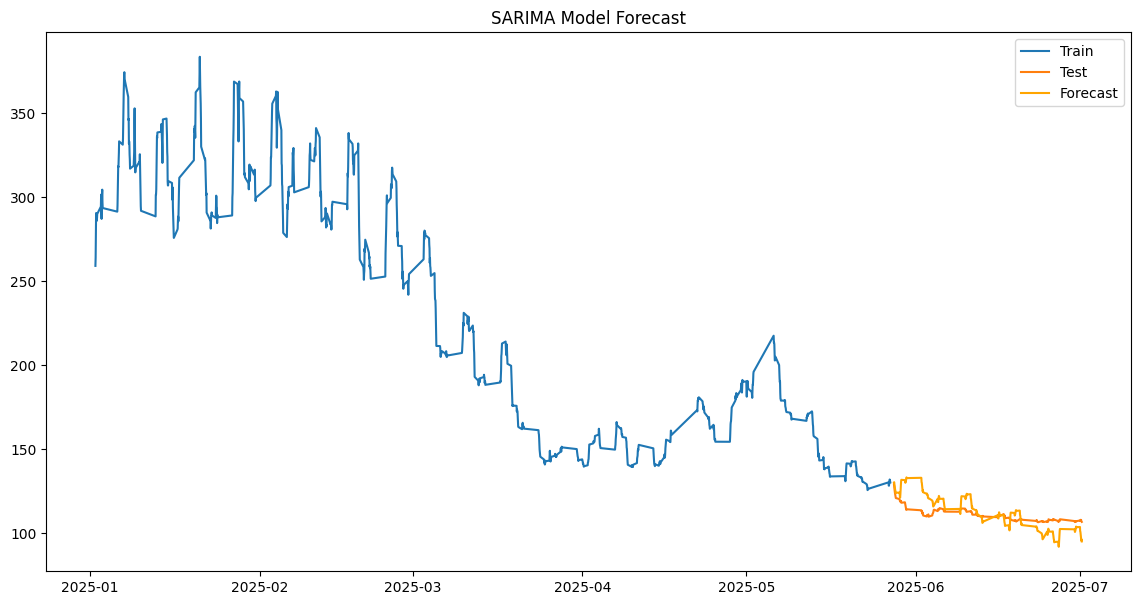

In [47]:
# draw the plot 绘制预测结果(用 predict得到的结果)
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, y_pred, label='Forecast', color='orange')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

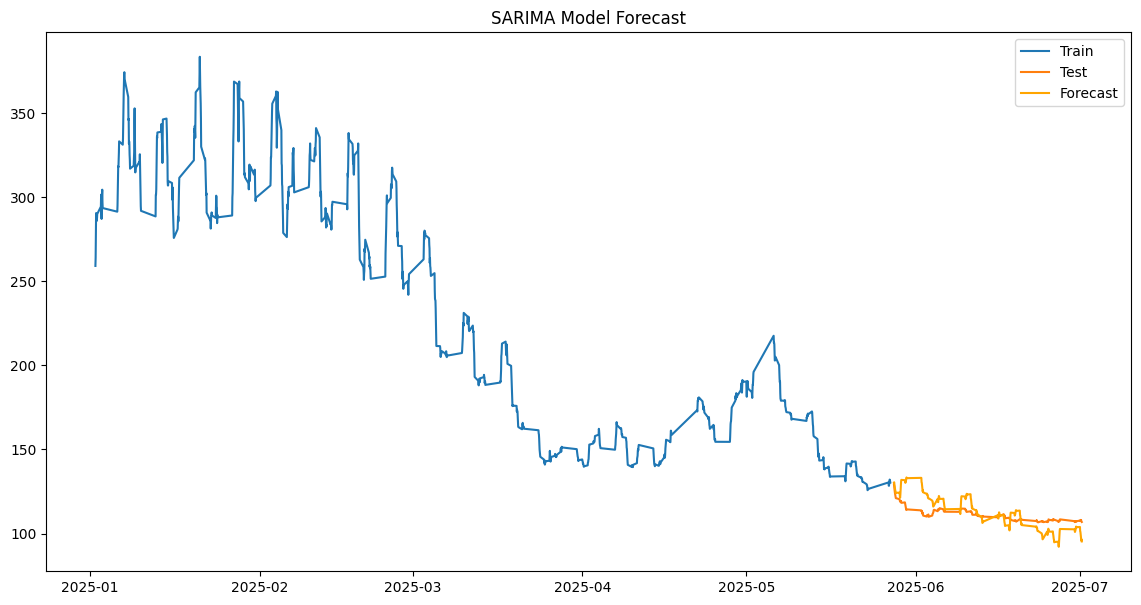

In [52]:
# 绘制预测结果(用 forcast得到的结果)
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_mean, label='Forecast', color='orange')
# plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()
plt.show()

C:\Users\yhb\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE for all: 10.999579570608251


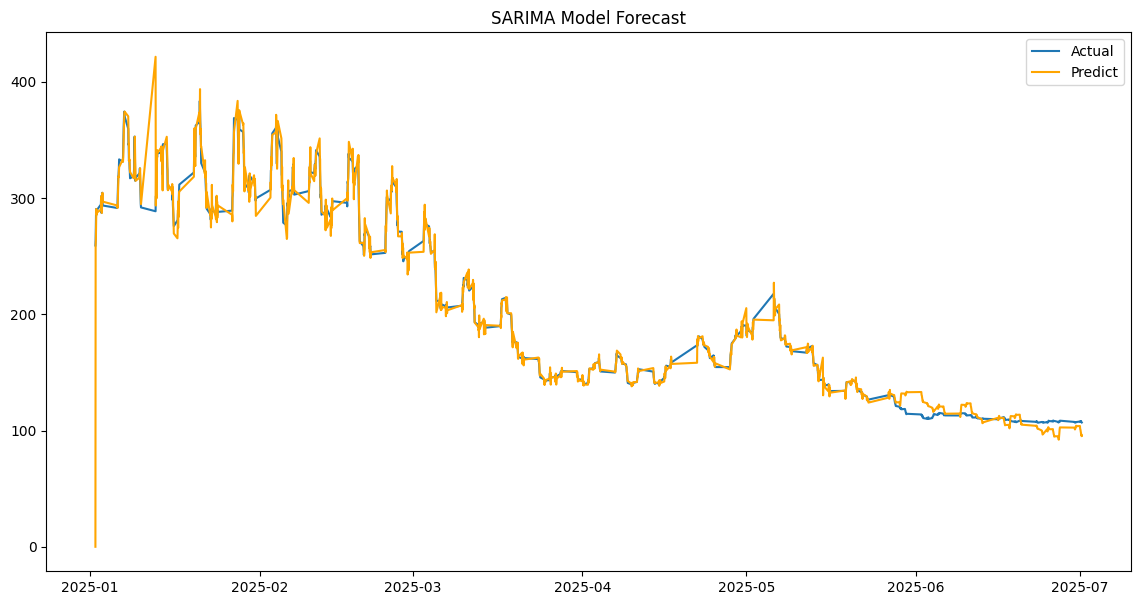

In [55]:
# use the whole dataset to predict and draw the plot
y_pred_all=results.predict(start=0, end=len(tape_data_hourly)-1, typ='levels')
rmse3=np.sqrt(mean_squared_error(tape_data_hourly['Price_mean'], y_pred_all))
print('RMSE for all:', rmse3)

# plot
plt.figure(figsize=(14, 7))
plt.plot(tape_data_hourly['Price_mean'], label='Actual')
plt.plot(tape_data_hourly.index, y_pred_all, label='Predict', color='orange')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()
